In [1]:
import cudf
import matplotlib.pyplot as plt
print(cudf.__version__)
import numpy as np
import cupy as cp
import pandas as pd
from tqdm import tqdm

23.04.01


In [14]:
chunk_size = 100000

chunks = []

# read the CSV file in chunks
for chunk in pd.read_csv('/workspaces/wiggle-face/keypoints_clean_yt_dataset.csv', chunksize=chunk_size):
    # pandas DataFrame chunk to cuDF DataFrame
    cudf_chunk = cudf.DataFrame.from_pandas(chunk)
    chunks.append(cudf_chunk)

# concatenate
df = cudf.concat(chunks, ignore_index=True)

print(df.head())

   infant_id  frame_id  keypoint_index  \
0          0      1052               1   
1          0      1052               2   
2          0      1052               3   
3          0      1052               4   
4          0      1052               5   

                                   keypoint  keypoint_score face_part  
0    (347.1287536621094, 387.8479817708333)        0.714166      Chin  
1  (340.10350545247394, 411.12335205078125)        0.803278      Chin  
2   (337.18776448567706, 454.8063659667969)        0.724702      Chin  
3  (337.18776448567706, 459.24217732747394)        0.764241      Chin  
4   (347.53797403971356, 463.0058898925781)        0.722450      Chin  


In [15]:
# split the keypoint column into 2 columns for the x and y coordinates
df[['x_coordinate', 'y_coordinate']] = df['keypoint'].str.extract(r'\(([^,]+), ([^,]+)\)').astype(np.float64)
df = df.drop(columns=['keypoint'])
df = df.sort_values(by=['infant_id', 'frame_id', 'keypoint_index']).reset_index(drop=True)
    
print(df.head(319))

     infant_id  frame_id  keypoint_index  keypoint_score    face_part  \
0            0      1052               1        0.714166         Chin   
1            0      1052               2        0.803278         Chin   
2            0      1052               3        0.724702         Chin   
3            0      1052               4        0.764241         Chin   
4            0      1052               5        0.722450         Chin   
..         ...       ...             ...             ...          ...   
314          0      1054             103        0.915345        Mouth   
315          0      1054             104        0.838654        Mouth   
316          0      1054             105        0.915550  Right_Pupil   
317          0      1054             106        0.913753   Left_Pupil   
318          0      1055               1        0.700717         Chin   

     x_coordinate  y_coordinate  
0      347.128754    387.847982  
1      340.103505    411.123352  
2      337.187764    

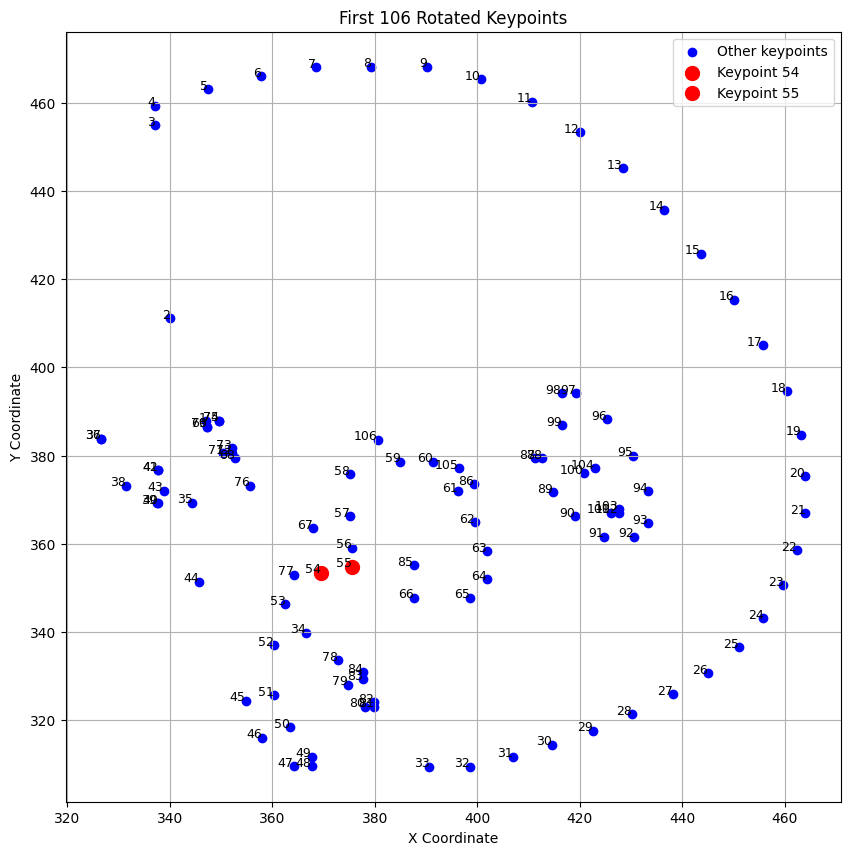

In [18]:
# figure
plt.figure(figsize=(10, 10))
x_coords = df['x_coordinate'][:106].values
y_coords = df['y_coordinate'][:106].values

x_coords = np.array(x_coords.get())
y_coords = np.array(y_coords.get())

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 53 
kp_55_index = 54

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')
plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
def move_and_rotate_keypoints(df):
    def get_rotation_matrix(angle):
        return cp.array([
            [-cp.cos(angle), -cp.sin(angle)],
            [cp.sin(angle), -cp.cos(angle)]
        ])

    def rotate_points(points, angle):
        rotation_matrix = get_rotation_matrix(angle)
        return cp.dot(points, rotation_matrix.T)
    
    result = []

    grouped = df.groupby(['infant_id', 'frame_id'])
    
    for (infant_id, frame_id), group in grouped:
        kp_54 = cp.array(group[group['keypoint_index'] == 54][['x_coordinate', 'y_coordinate']].values[0])
        kp_55 = cp.array(group[group['keypoint_index'] == 55][['x_coordinate', 'y_coordinate']].values[0])
        
        translated_coords = cp.array(group[['x_coordinate', 'y_coordinate']].values) - kp_54
        
        dx = kp_55[0] - kp_54[0]
        dy = kp_55[1] - kp_54[1]
        angle = cp.arctan2(dy, dx) - cp.pi / 2
        
        rotated_coords = rotate_points(translated_coords, angle)
        
        transformed_group = group.copy()
        transformed_group[['x_coordinate', 'y_coordinate']] = rotated_coords
        result.append(transformed_group)
    
    return cudf.concat(result).reset_index(drop=True)

transformed_df = move_and_rotate_keypoints(df)
print(transformed_df)

         infant_id  frame_id  keypoint_index  keypoint_score    face_part  \
0                0      1052               1        0.714166         Chin   
1                0      1052               2        0.803278         Chin   
2                0      1052               3        0.724702         Chin   
3                0      1052               4        0.764241         Chin   
4                0      1052               5        0.722450         Chin   
...            ...       ...             ...             ...          ...   
1723025        369      1922             102        0.848633        Mouth   
1723026        369      1922             103        0.893027        Mouth   
1723027        369      1922             104        0.869866        Mouth   
1723028        369      1922             105        0.902219  Right_Pupil   
1723029        369      1922             106        0.955192   Left_Pupil   

         x_coordinate  y_coordinate  
0           38.415877     14.327003  

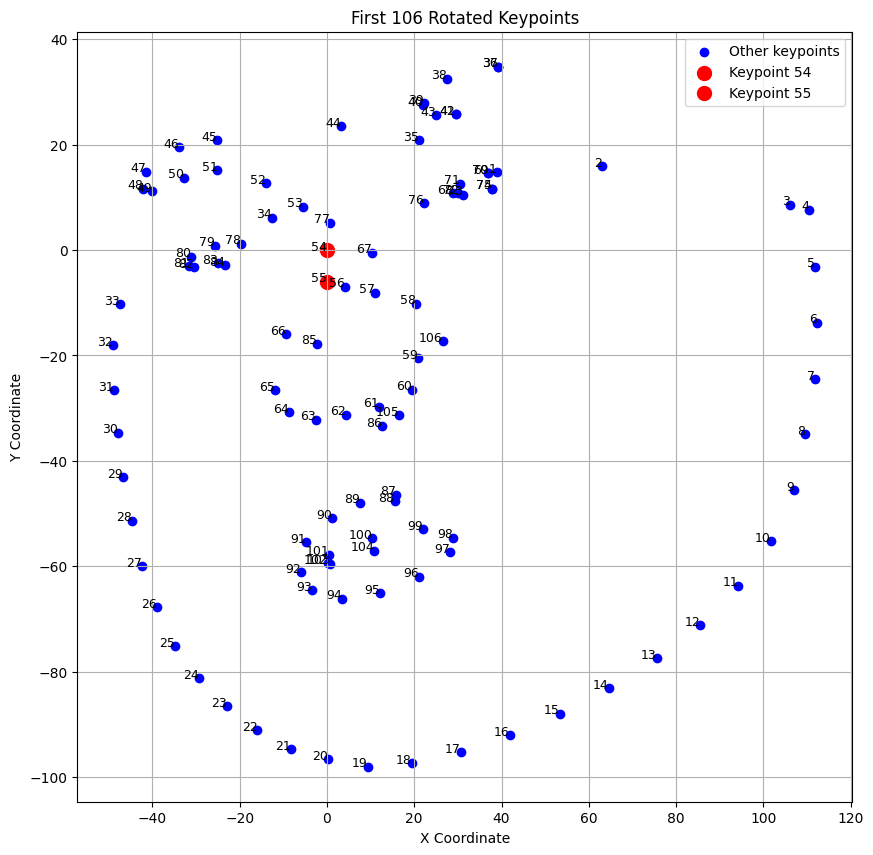

In [19]:
# figure
plt.figure(figsize=(10, 10))

x_coords = transformed_df['x_coordinate'][106:212].values
y_coords = transformed_df['y_coordinate'][106:212].values

x_coords = np.array(x_coords.get())
y_coords = np.array(y_coords.get())

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_54_index = 53  
kp_55_index = 54  

plt.scatter(x_coords[kp_54_index], y_coords[kp_54_index], c='red', marker='o', label='Keypoint 54', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')

plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
df.head(107)

,infant_id,frame_id,keypoint_index,keypoint_score,face_part,x_coordinate,y_coordinate
0,0,1052,1,0.714166,Chin,347.128754,387.847982
1,0,1052,2,0.803278,Chin,340.103505,411.123352
2,0,1052,3,0.724702,Chin,337.187764,454.806366
3,0,1052,4,0.764241,Chin,337.187764,459.242177
4,0,1052,5,0.722450,Chin,347.537974,463.005890
...,...,...,...,...,...,...,...
102,0,1052,103,0.928198,Mouth,427.651347,367.837657
103,0,1052,104,0.869305,Mouth,422.946706,377.112518
104,0,1052,105,0.920545,Right_Pupil,396.466278,377.112518
105,0,1052,106,0.910548,Left_Pupil,380.604899,383.564596


In [26]:
transformed_df.head(107)

,infant_id,frame_id,keypoint_index,keypoint_score,face_part,x_coordinate,y_coordinate
0,0,1052,1,0.714166,Chin,38.415877,14.327003
1,0,1052,2,0.803278,Chin,62.660984,16.135810
2,0,1052,3,0.724702,Chin,105.936286,9.505919
3,0,1052,4,0.764241,Chin,110.266468,8.543654
4,0,1052,5,0.722450,Chin,111.695273,-2.376551
...,...,...,...,...,...,...,...
102,0,1052,103,0.928198,Mouth,1.414214,-59.937241
103,0,1052,104,0.869305,Mouth,11.488795,-57.356637
104,0,1052,105,0.920545,Right_Pupil,17.233221,-31.506789
105,0,1052,106,0.910548,Left_Pupil,26.972479,-17.422774


In [27]:
df = transformed_df

In [35]:
# new dataframe with unique infant_id and frame_id combinations
face_feature_df = df[['infant_id', 'frame_id']].drop_duplicates().reset_index(drop=True)

# keypoint indices for the left and right eyebrows
left_brow_indices = cp.array(list(range(34, 43)))
right_brow_indices = cp.array(list(range(43, 52)))
lip_pairs = [(100, 102), (99, 103), (98, 104)]
right_eye_pairs = [(79, 81), (78, 82), (77, 83)]
left_eye_pairs = [(70, 72), (69, 73), (68, 74)]

# dataframe columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
frame_ids = cp.array(df['frame_id'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
y_coords = cp.array(df['y_coordinate'].values)

# func to calculate the mean y-coordinate for specified keypoints
def calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, brow_indices):
    mask = (infant_ids == infant_id) & (frame_ids == frame_id) & (cp.isin(keypoint_indices, brow_indices))
    return y_coords[mask].mean()

# func to calculate the mean distance between specified keypoints
def calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, points):
    distances = []
    for p1, p2 in points:
        mask1 = (infant_ids == infant_id) & (frame_ids == frame_id) & (keypoint_indices == p1)
        mask2 = (infant_ids == infant_id) & (frame_ids == frame_id) & (keypoint_indices == p2)
        kp1 = y_coords[mask1]
        kp2 = y_coords[mask2]
        if kp1.size > 0 and kp2.size > 0:
            distance = cp.abs(kp1 - kp2)
            distances.append(distance)
    return cp.mean(cp.array(distances)) if distances else cp.nan

In [36]:
# calculate mean y-coordinates for the eyebrows with progress tracking
mean_y_coord_left_brow = []
mean_y_coord_right_brow = []

for index in tqdm(range(len(face_feature_df)), desc='Calculating mean y-coordinates for eyebrows'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    mean_y_coord_left_brow.append(
        calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, left_brow_indices).get()
    )
    mean_y_coord_right_brow.append(
        calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, right_brow_indices).get()
    )

# add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow

print(face_feature_df)


Calculating mean y-coordinates for eyebrows: 100%|██████████| 16255/16255 [00:26<00:00, 606.64it/s]


       infant_id  frame_id  mean_y_coord_left_brow  mean_y_coord_right_brow
0              0      1052               26.348788                17.127944
1              0      1053               26.198250                17.315864
2              0      1054               26.715033                17.514939
3              0      1055               26.413779                17.454999
4              0      1056               26.339764                17.688944
...          ...       ...                     ...                      ...
16250        369      1918               33.724684                43.118234
16251        369      1919               34.059471                43.134465
16252        369      1920               34.205876                42.740573
16253        369      1921               33.659804                42.891995
16254        369      1922               32.333658                43.686978

[16255 rows x 4 columns]


In [37]:
# calculate distances with progress tracking
right_eye_eyelid_distance = []
left_eye_eyelid_distance = []
lip_distance = []

# iterate over each row in the face_feature_df
for index in tqdm(range(len(face_feature_df)), desc='Calculating distances for keypoints'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    right_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, right_eye_pairs).get()
    )
    left_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, left_eye_pairs).get()
    )
    lip_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, lip_pairs).get()
    )

Calculating distances for keypoints: 100%|██████████| 16255/16255 [03:14<00:00, 83.62it/s]


In [38]:
# add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow
face_feature_df['right_eye_eyelid_distance'] = right_eye_eyelid_distance
face_feature_df['left_eye_eyelid_distance'] = left_eye_eyelid_distance
face_feature_df['lip_distance'] = lip_distance

# determine if the eyes and mouth are closed based on the distances
threshold_eyes = 0.8
threshold_mouth =  0.3 
face_feature_df['right_eye_closed'] = face_feature_df['right_eye_eyelid_distance'] < threshold_eyes
face_feature_df['left_eye_closed'] = face_feature_df['left_eye_eyelid_distance'] < threshold_eyes
face_feature_df['mouth_closed'] = face_feature_df['lip_distance'] < threshold_mouth

print(face_feature_df)

       infant_id  frame_id  mean_y_coord_left_brow  mean_y_coord_right_brow  \
0              0      1052               26.348788                17.127944   
1              0      1053               26.198250                17.315864   
2              0      1054               26.715033                17.514939   
3              0      1055               26.413779                17.454999   
4              0      1056               26.339764                17.688944   
...          ...       ...                     ...                      ...   
16250        369      1918               33.724684                43.118234   
16251        369      1919               34.059471                43.134465   
16252        369      1920               34.205876                42.740573   
16253        369      1921               33.659804                42.891995   
16254        369      1922               32.333658                43.686978   

       right_eye_eyelid_distance  left_eye_eyelid_d

In [39]:
# 43 - 47 upper right brow 
# 48 - 51 lower right brow
# 34 - 38 upper left brow 
# 39 - 42 lower left brow
# 67 - 71 upper left eyelid
# 72 - 74 lower left eyelid
# 76 - 80 upper right eyelid
# 81 - 83 lower right eyelid
# 85 - 91 upper outer lip
# 92 - 97 lower outer lip
# 98 - 101 upper inner lip
# 102 - 104 lower inner lip 

# function for curvatures
def calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, indices):
    mask = (infant_ids == infant_id) & (frame_ids == frame_id) & (cp.isin(keypoint_indices, indices))
    x_coords_filtered = x_coords[mask]
    y_coords_filtered = y_coords[mask]
    
    if len(x_coords_filtered) < 3 or len(y_coords_filtered) < 3:
        return cp.nan  # Need at least 3 points to calculate second derivative
    
    x_second_derivative = cp.gradient(cp.gradient(x_coords_filtered))
    y_second_derivative = cp.gradient(cp.gradient(y_coords_filtered))
    curvature = cp.mean(cp.sqrt(x_second_derivative**2 + y_second_derivative**2))
    return curvature

In [40]:
# keypoint indices for the specified face parts
upper_right_brow_indices = cp.array(list(range(43, 48)))
lower_right_brow_indices = cp.array(list(range(48, 52)))
upper_left_brow_indices = cp.array(list(range(34, 39)))
lower_left_brow_indices = cp.array(list(range(39, 43)))
upper_left_eyelid_indices = cp.array(list(range(67, 72)))
lower_left_eyelid_indices = cp.array(list(range(72, 75)))
upper_right_eyelid_indices = cp.array(list(range(76, 81)))
lower_right_eyelid_indices = cp.array(list(range(81, 84)))
upper_outer_lip_indices = cp.array(list(range(85, 92)))
lower_outer_lip_indices = cp.array(list(range(92, 98)))
upper_inner_lip_indices = cp.array(list(range(98, 102)))
lower_inner_lip_indices = cp.array(list(range(102, 105)))

# dataFrame columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
frame_ids = cp.array(df['frame_id'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
x_coords = cp.array(df['x_coordinate'].values)
y_coords = cp.array(df['y_coordinate'].values)

# calculate curvatures for each specified face part
curvature_upper_right_brow = []
curvature_lower_right_brow = []
curvature_upper_left_brow = []
curvature_lower_left_brow = []
curvature_upper_left_eyelid = []
curvature_lower_left_eyelid = []
curvature_upper_right_eyelid = []
curvature_lower_right_eyelid = []
curvature_upper_outer_lip = []
curvature_lower_outer_lip = []
curvature_upper_inner_lip = []
curvature_lower_inner_lip = []

for index in tqdm(range(len(face_feature_df)), desc='Calculating curvatures for specified face parts'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    curvature_upper_right_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_right_brow_indices).get()
    )
    curvature_lower_right_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_right_brow_indices).get()
    )
    curvature_upper_left_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_left_brow_indices).get()
    )
    curvature_lower_left_brow.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_left_brow_indices).get()
    )
    curvature_upper_left_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_left_eyelid_indices).get()
    )
    curvature_lower_left_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_left_eyelid_indices).get()
    )
    curvature_upper_right_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_right_eyelid_indices).get()
    )
    curvature_lower_right_eyelid.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_right_eyelid_indices).get()
    )
    curvature_upper_outer_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_outer_lip_indices).get()
    )
    curvature_lower_outer_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_outer_lip_indices).get()
    )
    curvature_upper_inner_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, upper_inner_lip_indices).get()
    )
    curvature_lower_inner_lip.append(
        calculate_curvature_cp(infant_ids, frame_ids, keypoint_indices, x_coords, y_coords, infant_id, frame_id, lower_inner_lip_indices).get()
    )

# add the curvature results back to the DataFrame
face_feature_df['curvature_upper_right_brow'] = curvature_upper_right_brow
face_feature_df['curvature_lower_right_brow'] = curvature_lower_right_brow
face_feature_df['curvature_upper_left_brow'] = curvature_upper_left_brow
face_feature_df['curvature_lower_left_brow'] = curvature_lower_left_brow
face_feature_df['curvature_upper_left_eyelid'] = curvature_upper_left_eyelid
face_feature_df['curvature_lower_left_eyelid'] = curvature_lower_left_eyelid
face_feature_df['curvature_upper_right_eyelid'] = curvature_upper_right_eyelid
face_feature_df['curvature_lower_right_eyelid'] = curvature_lower_right_eyelid
face_feature_df['curvature_upper_outer_lip'] = curvature_upper_outer_lip
face_feature_df['curvature_lower_outer_lip'] = curvature_lower_outer_lip
face_feature_df['curvature_upper_inner_lip'] = curvature_upper_inner_lip
face_feature_df['curvature_lower_inner_lip'] = curvature_lower_inner_lip

print(face_feature_df)

Calculating curvatures for specified face parts:   0%|          | 0/16255 [00:00<?, ?it/s]

Calculating curvatures for specified face parts: 100%|██████████| 16255/16255 [04:57<00:00, 54.58it/s]


       infant_id  frame_id  mean_y_coord_left_brow  mean_y_coord_right_brow  \
0              0      1052               26.348788                17.127944   
1              0      1053               26.198250                17.315864   
2              0      1054               26.715033                17.514939   
3              0      1055               26.413779                17.454999   
4              0      1056               26.339764                17.688944   
...          ...       ...                     ...                      ...   
16250        369      1918               33.724684                43.118234   
16251        369      1919               34.059471                43.134465   
16252        369      1920               34.205876                42.740573   
16253        369      1921               33.659804                42.891995   
16254        369      1922               32.333658                43.686978   

       right_eye_eyelid_distance  left_eye_eyelid_d

In [41]:
face_feature_df.head(10)

,infant_id,frame_id,mean_y_coord_left_brow,mean_y_coord_right_brow,right_eye_eyelid_distance,left_eye_eyelid_distance,lip_distance,right_eye_closed,left_eye_closed,mouth_closed,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,0,1052,26.348788,17.127944,5.550000,2.809016,4.694662,False,False,False,...,11.111430,2.824883,6.723070,2.855397,3.413346,2.344622,4.729379,2.265034,2.037664,4.843724
1,0,1053,26.198250,17.315864,5.347490,2.865359,4.537808,False,False,False,...,11.097507,2.847779,6.694395,2.885228,3.415470,2.350449,4.683896,2.245411,2.065836,4.851396
2,0,1054,26.715033,17.514939,5.421089,2.763375,4.664919,False,False,False,...,11.153215,2.903221,6.676370,2.843963,3.465242,2.312536,4.688894,2.235913,2.028987,4.858052
3,0,1055,26.413779,17.454999,5.608964,2.973785,4.289533,False,False,False,...,11.135602,2.879256,6.702055,2.731833,3.437882,2.269315,4.632252,2.204493,2.008019,4.823562
4,0,1056,26.339764,17.688944,5.519994,2.826190,4.047135,False,False,False,...,11.205075,2.884650,6.657463,2.736643,3.418091,2.242292,4.664352,2.241005,1.932819,4.877589
5,0,1057,26.800478,17.018553,5.905682,3.219371,4.432451,False,False,False,...,11.158769,2.907022,6.677693,2.676728,3.409422,2.239225,4.662863,2.186881,1.990597,4.864415
6,0,1058,26.210369,17.980474,5.361088,2.982106,3.972951,False,False,False,...,11.117427,2.891987,6.635313,2.642912,3.452225,2.225247,4.689694,2.151649,2.005203,4.797330
7,0,1059,26.673297,17.311865,5.654298,3.137977,4.471179,False,False,False,...,11.163941,2.894422,6.648241,2.661142,3.412086,2.287297,4.661045,2.171986,1.996862,4.836110
8,0,1060,27.130633,16.944667,5.895187,3.172633,4.645962,False,False,False,...,11.186713,2.959633,6.677680,2.628119,3.440977,2.198574,4.680449,2.183676,1.951376,4.746977
9,0,1061,27.564543,16.401343,6.202565,3.213017,5.028631,False,False,False,...,11.216672,2.972429,6.684235,2.742727,3.443310,2.211824,4.662198,2.213302,1.953490,4.717802


In [42]:
face_feature_df.to_csv('face_features_with_curvatures.csv', index=False)

In [75]:
# function to calculate displacement manually
def calculate_manual_displacement(group):
    group['shifted_x'] = group['x_coordinate'].shift(1)
    group['shifted_y'] = group['y_coordinate'].shift(1)

    group['interframe_x_displacement'] = group['x_coordinate'] -  group['shifted_x']
    group['interframe_y_displacement'] =  group['y_coordinate'] - group['shifted_y']

    group['interframe_x_displacement'] = group['interframe_x_displacement'].fillna(0)
    group['interframe_y_displacement'] = group['interframe_y_displacement'].fillna(0)
    
    return group

# displacement for all keypoints
df = df.groupby(['infant_id', 'keypoint_index']).apply(calculate_manual_displacement).reset_index(drop=True)
df = df.drop(columns = ['shifted_x','shifted_y'])
df.loc[df['frame_id'] == 0, ['interframe_x_displacement', 'interframe_y_displacement']] = 0.0

print(df.head(1320))

/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/cudf/core/groupby/groupby.py:1169: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 6890 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


      infant_id  frame_id  keypoint_score face_part  keypoint_index  \
0             0         0        0.577999      Chin               1   
1             0         1        0.514304      Chin               1   
2             0         2        0.493515      Chin               1   
3             0         3        0.466503      Chin               1   
4             0         4        0.473813      Chin               1   
...         ...       ...             ...       ...             ...   
1315          0      1315        0.711513      Chin               1   
1316          0      1316        0.703581      Chin               1   
1317          0      1317        0.721716      Chin               1   
1318          0      1318        0.754950      Chin               1   
1319          0         0        0.752206      Chin               2   

      x_coordinate  y_coordinate  interframe_x_displacement  \
0       351.601135    463.115295                   0.000000   
1       349.961029   

In [76]:
df.to_csv('displacements.csv', index=False)

In [77]:
mean_displacements = df.groupby(['infant_id', 'keypoint_index'])[['interframe_x_displacement', 'interframe_y_displacement']].mean().reset_index()
mean_displacements.rename(columns={
    'interframe_x_displacement': 'mean_x_displacement_keypoint',
    'interframe_y_displacement': 'mean_y_displacement_keypoint'
}, inplace=True)

# calculating the average confidence per keypoint per infant, based on keypoint_scores 
average_confidence = df.groupby(['infant_id', 'keypoint_index'])['keypoint_score'].mean().reset_index()
average_confidence.rename(columns={'keypoint_score': 'average_confidence_keypoint'}, inplace=True)
face_parts = df[['infant_id', 'keypoint_index', 'face_part']].drop_duplicates()

# merge all metrics
metrics_df = cudf.merge(mean_displacements, average_confidence, on=['infant_id', 'keypoint_index'])
metrics_df = cudf.merge(metrics_df, face_parts, on=['infant_id', 'keypoint_index'])

metrics_df = metrics_df.sort_values(by=['infant_id', 'keypoint_index'])
metrics_df = metrics_df.reset_index(drop=True)

print(metrics_df.head(107))

     infant_id  keypoint_index  mean_x_displacement_keypoint  \
0            0               1                     -0.108792   
1            0               2                     -0.104563   
2            0               3                     -0.100725   
3            0               4                     -0.097220   
4            0               5                     -0.093938   
..         ...             ...                           ...   
102          0             103                     -0.091342   
103          0             104                     -0.090394   
104          0             105                     -0.109413   
105          0             106                     -0.115715   
106          1               1                      0.000633   

     mean_y_displacement_keypoint  average_confidence_keypoint    face_part  
0                        0.010605                     0.495667         Chin  
1                        0.009601                     0.778484         Chin

In [78]:
metrics_df.to_csv('keypoints_metrics.csv', index=False)